In [515]:
import json
import pandas as pd
import requests
import datetime
from binance import Client
import matplotlib.pyplot as plt
import numpy as np
import os
from binance.client import Client
import datetime, time
from datetime import datetime
from numba import jit
import math

# Бэктест_начало


In [523]:
################### Задаем даты начала и конца бектеста ###############
start_date = '12/01/2020'
end_date = '26/12/2022'
################## Инициализация параметров обучения ######################
n_info = 12 # часов для обучения (не совсем обучение, скорее зависимая часть, задает инертность)
n_forcast = 24 # на какой период предсказываем
intervals_in_hour = 12 # какими интервалами оперируем здесь 12 - 5 минутки

################## Указываем ожидаемую доходность ##################
IR = 0.9 # ежедневная доходность выраженная в процентах// при полном угадывании интервала и волатильности 0.04
# волотильность была 4 процента, доходность 0.3 процента. Однако предсказанный интервал был в 3 раза больше чем реальный.

CUT_OFF = 0.15 # относительная ширина интервала, превышение которой стоит переждать


In [517]:

def GetHistoricalData(symbol, interval, fromDate, toDate):
    klines = client.get_historical_klines(symbol, interval, fromDate, toDate)
    df = pd.DataFrame(klines, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms')
    df['date'] = df.dateTime.dt.strftime("%d/%m/%Y")
    df['time'] = df.dateTime.dt.strftime("%H:%M:%S")
    df = df.drop(['dateTime', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)
    column_names = ["date", "time", "open","close", "high", "low", "volume"]
    df = df.reindex(columns=column_names)
    return df
    
api_key = ""
api_secret = ""
client = Client(api_key, api_secret)


fromDate = str(datetime.strptime(start_date, '%d/%m/%Y'))
toDate = str(datetime.strptime(end_date, '%d/%m/%Y'))
symbol = "ETHUSDT"
interval = Client.KLINE_INTERVAL_5MINUTE
df = GetHistoricalData(symbol, interval, fromDate, toDate)

## Определим функции прибыли:  
Пока они вне класса, нужно внести их. 


In [518]:
def unforward_earnings(start_price, end_price, high_board, low_board):
    """Функция должна получить всю необходимую информацию и возвратить итоговую прибыль-убыток в пуле.
    Тут не учитываются заработанные комиссии. Только изменение стоимости токенов и их соотношение"""
    # Если после 24(или другого) периода цена оказалась выше изначальной
    p_ETH = (high_board-start_price)/(high_board-low_board)# доля ETH
    p_USDT = (1-p_ETH)# доля USDT
    if end_price >= start_price:
        if end_price >= high_board:
            res = ((high_board-start_price)/2+start_price)/start_price*p_ETH+p_USDT
        else:
            p = (end_price-start_price)/(high_board-start_price) # доля проданного ETH
            a1 = ((end_price-start_price)/2+start_price)/start_price*p*p_ETH
            a2 = p_USDT
            a3 = p_ETH*(1-p)*(end_price)/start_price #непроданный ETH
            res =  a1+a2+a3
    elif end_price < start_price:
        if end_price <= low_board:
            res = (p_USDT/(low_board+(start_price - low_board)/2)+p_ETH/start_price)*end_price
        else:
            p = (start_price-end_price)/(start_price-low_board) # доля обменянных долларов
            a1 = p_USDT*p/(end_price+(start_price - end_price)/2)*end_price# сумма от обменянных долларов
            a2 = p_USDT*(1-p) # остатки долларов
            a3 = p_ETH*end_price/start_price# изначальный подешевевший эфир
            res =  a1+a2+a3
    return (res-1)*100 # возвращаем результат в процентах!

def simple_hedge(start_price, end_price, ratio):
    '''Данная функция принимает начальную и конечную стоимость. А так же параметры хеджирования - долю хеджа
    Возвращает процентный заработок/убыток из за хеджа в % '''
    res = -(end_price-start_price)/start_price
    return res*100*ratio


def return_curent_eth(start_price, end_price, high_board, low_board, eth_pool, usd_pool):
    '''Функция возвращает количество эфира для хеджа, в долларах'''
    # Исходим из того, что равномерно размазаны именно доллары! И эфир в тиках в долларах
    if end_price >= start_price:
        if end_price >= high_board:
            # у нас только usdt
            res = 0
        else:
            p = (end_price-start_price)/(high_board-start_price) # доля проданного ETH (в долларах)
            res = eth_pool*(1-p)
    elif end_price < start_price:
        if end_price <= low_board:
            # долларов нет, все это эфир
            res = usd_pool+eth_pool # в результате имеем старый и новый эфир
        else:
            # рассчитаем сколько долларов стали ETH
            p = (start_price-end_price)/(start_price-low_board)# доля обменянных долларов
            res =  p*usd_pool+eth_pool
    return res


def dynamic_hedge(eth_pool, usd_pool, high_board,
                                   low_board, start_price, end_price, index, dict_res, n_forcast,
                  intervals_in_hour, n_info):
    """Будет делать рехедж n раз за все время
    Для этого нам потребуется open, close за все время сидения в пуле
    Изначально хеджируется весь эфир, затем, вместе с движением цены изменяется доля эфира в пуле.
    Требуется изменять хедж.
    Поскольку мы принебрегаем комиссиями, в данной реализации, считаем,
    что каждый раз мы закрываем позицию и открываем новую на другую сумму
    """
    n_rehedge = 3 # сколько раз делаеся рехедж
    # преобразуем индекс (сложная штука из за того, что до этого использовали каждую 24*12 строчку)
    i = index*n_forcast*intervals_in_hour # получаем индекс в массиве всех строк
    index_in_dict_res = i+intervals_in_hour*n_info # тут i это сплошной, 

    open_prices = dict_res[index_in_dict_res][1]['open'].values.astype(float)
    close_prices = dict_res[index_in_dict_res][1]['close'].values.astype(float)
    leverage = 1
    current_hedge = eth_pool
    money = eth_pool
    start_price0 = start_price
    for i in range(1, n_rehedge+2):
         # 1 - закрываем позицю по хеджу, фиксируем прибыль/убытки
        # 2 - считаем размер новой позиции. Тут потребуется плечо - то есть его рассчет и использование
        # перезаписываем текущую позицию
         
        # смотрим цену закрытия
        ind = i*n_forcast*intervals_in_hour/(n_rehedge+1)-1 # 5минутка для закрытия позиции
        ind = int(ind)
        close_price = close_prices[ind]
        # считаем доходы по закрытому хеджу (фьючу)
        earning = -(close_price-start_price)/start_price*current_hedge*leverage
        money += earning
        if i == n_rehedge+1:
            break
        # смотрим сколько эфира нужно захеджировать
        ETH_to_hedge = return_curent_eth(start_price0, close_price, high_board, low_board, eth_pool, usd_pool)
        
        # выбираем плечо, максимально 3е, не больше. Основываемся на том, сколько у нас средств
        leverage = math.ceil(ETH_to_hedge/money)
        if ETH_to_hedge == 0:
            current_hedge = 0
        elif leverage > 3:
            print('требуется плечо - ',leverage)
            leverage = 3
            # все деньги, максимальное плечо
            current_hedge = money
        elif leverage <= 3:
            current_hedge = ETH_to_hedge/leverage
        # изменяем цену старта для нового фьючерса
        start_price = open_prices[ind+1]
    

    return money-eth_pool
        

def persentage_earnings(index, dict_res, high_board, low_board, start_price, n_forcast,
                  intervals_in_hour, n_info):
    '''Функция принимает необходимые параметры и рассчитывает доходность в % от всех изначальных инвестиций'''
#     res = const

    i = index*n_forcast*intervals_in_hour # получаем индекс в массиве всех строк
    index_in_dict_res = i+intervals_in_hour*n_info # тут i это сплошной, 

    low_prices = dict_res[index_in_dict_res][1]['low'].values.astype(float)
    high_prices = dict_res[index_in_dict_res][1]['high'].values.astype(float)
    
    real_vola = (np.max(high_prices) - np.min(low_prices))/start_price
    
    pred_vola = (high_board - low_board)/start_price
    print('real_vola, pred_vola')
    print(real_vola, pred_vola)

    # учтем, что чем больше реальная волотильность, тем выше доходность
    res = IR*(real_vola/0.04)
    # если реальный интервал больше, то требуется уменьшить доходность, если меньше, тоже
    res = real_vola/pred_vola*res if pred_vola > real_vola else pred_vola/real_vola*res # тут ручками задать 
    # меньше чем 0.1% получить просто невозможно
    res = max(0.1, res)
    
    # накинем комиссию за фьючерсы(консервативно)
    res = res - 0.1
    print('Доходность ', res)
    print()
    return res

def calc_ratio(start_price, high_board, low_board):
    return (high_board-start_price)/(high_board-low_board)
    


### Далее класс, его просто инициализировать

In [519]:
# Класс который принимаем в себя всю необходимую информацию и подготавливает данные, рассчитывает интервалы и тп
class Interval_calculator:
    def __init__(self, df, n_info, n_forcast, intervals_in_hour, calculation='slow'):
        self.calculation = calculation
        self.df = df
        self.n_info = n_info
        self.n_forcast = n_forcast
        self.intervals_in_hour = intervals_in_hour
        self.make_new_col()
        self.preob()
        self.calculate_intervals()
        self.make_data_for_back()
        self.get_periodic()
        self.make_dates()
    
    def make_dates(self):
        n_info, n_forcast, intervals_in_hour = self.n_info, self.n_forcast, self.intervals_in_hour
        df_for_dates = self.df.iloc[n_info*intervals_in_hour:len(df)-n_forcast*intervals_in_hour]
        dates = df_for_dates['date'].values
        final_dates = dates[::intervals_in_hour*n_forcast]
        self.dates = final_dates
        
    def make_new_col(self):
        '''Потребуются относительные изменения'''
        print('Добавляю относительные изменения')
        df = self.df
        mass = np.zeros(len(df))
        mass[0] = 1 # первую точку доопределяем 1
        values = df['open'].values.astype(float)
        for i in range(1, len(df)):
            mass[i] = values[i]/values[i-1]
            df['change'] = mass
        self.df = df
        return    
        
        
    def preob(self):
        '''Функция просто создает кучу разбивок для бутстрэпа и предсказания
        df - датасет
        n_info - сколько часов брать для "обучения"
        n_forcast - на сколько часов давать прогноз
        intervals_in_hour - количество выбранных интерваллов в часе (если минутные данные то 60)
        '''
        print('Создаю разбивку - данные для рассчета интервала и теста')
        df, n_info, n_forcast, intervals_in_hour = self.df, self.n_info, self.n_forcast, self.intervals_in_hour
        self.dict_res = {}
        for i in range(n_info*intervals_in_hour, len(df)-n_forcast*intervals_in_hour):
            fold_info = df[i-n_info*intervals_in_hour : i] # Срез датасета
            fold_res = df[i : i+n_forcast*intervals_in_hour] # Срез датасета
            self.dict_res[i] = [fold_info, fold_res] # В словаре лежат два датасета под каждым ключом
        return 
    
    @jit
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
        '''Функция бутстрэпит изменения за прошедшие часы (это длина массива) n_forcast*intervals_in_hour раз, 
        процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
        mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
        mass = np.array(mass) # переводим в numpy
        n = len(mass) # длина выборки для обучения
        size_forecast = n_forcast*intervals_in_hour
        # случайно берем числа до n, размера n_forcast*intervals_in_hour
        indexes = np.random.randint(n, size=size_forecast*10000)
        change = mass[[indexes]]
        change = change.reshape((10000, size_forecast))
        # теперь рассомтрим куммулятивное перемножение- предсказанное поведение
        cum_change = np.cumprod(change, axis=1)
        # минимальное и максимальные значения внутри временного интервалла
        min_ = np.min(cum_change, axis=1)
        max_ = np.max(cum_change, axis=1)
        sorted_res_min = np.sort(min_)
        sorted_res_max = np.sort(max_)
        high, low = sorted_res_max[9900], sorted_res_min[100]
#         vol = max((high-1), (1-low))
#         return np.array([1+vol, 1-vol])
        return np.array([high, low])
    
    def get_real(self, df):
      '''Функция нужна для валидации - возвращает верхние и нижние границы'''
      high = df['high'].values.astype(float)
      low = df['low'].values.astype(float)
      return np.hstack([high, low])
    
    def calculate_intervals(self):
        print('Рассчитываю интерваллы')
        dict_res, n_forcast, intervals_in_hour = self.dict_res, self.n_forcast, self.intervals_in_hour
        calculated_intervals = np.zeros((len(dict_res), 2))
        real_intervals = np.zeros((len(dict_res), n_forcast*intervals_in_hour*2)) # запоминаем  всю динамику  умножение на 2 тк записываем для верха и для низа
        k = 0
        for key in dict_res:
            if (self.calculation == 'fast') and (k % (self.intervals_in_hour*self.n_forcast) != 0 ):
                # заполняем ненужные интервалы нулями
                calculated_intervals[k, 0:2] = 0
                real_intervals[k, :] = 0
                k += 1
                continue
            real_intervals[k, :] = self.get_real(dict_res[key][1])

            # требуется для абсолютных значений запомнить цену открытия
            last_value = dict_res[key][0]['open'].values.astype(float)[-1]

            calculated = self.bootstrap(dict_res[key][0]['change'].values, n_forcast, intervals_in_hour)

            calculated_intervals[k, 0:2] = calculated*last_value
            k += 1
            j = int(len(dict_res)/200)
            if k % j == 0:
                print('progress = {} %'.format(round(k/len(dict_res)*100, 3)))
        self.intervals = calculated_intervals, real_intervals
        return

    def make_data_for_back(self):
        print('Преобразую данные для бэктеста')
        intervals, n_forcast, intervals_in_hour = self.intervals, self.n_forcast, self.intervals_in_hour
        # mass high, low, start, end
#         k_end = n_forcast*intervals_in_hour-1
        mass = np.zeros((len(intervals[0]), 4))
        for i in range(len(intervals[0])):
            # вычислим индекс в словаре с нарезками, чтобы подтянуть реальную цену открытия и закрытия
            index_in_dict_res = i+intervals_in_hour*self.n_info
            # берем цену open, close 
            open_price = self.dict_res[index_in_dict_res][1]['open'].values[0]
            close_price = self.dict_res[index_in_dict_res][1]['close'].values[-1]
            mass[i, :] = *intervals[0][i], open_price, close_price
            ###### тут брались цены open,close как high в первую и последнюю 5 минутки 
#             mass[i, :] = *intervals[0][i] , intervals[1][i][0], intervals[1][i][k_end]
    #         intervals[0][i] - high, low
        
    #         intervals[1][i][0] - start
    #         intervals[1][i][k] - end
        self.data_for_back = mass
        return
  
    
    def get_periodic(self):
        data_for_back, n_forcast, intervals_in_hour = self.data_for_back, self.n_forcast, self.intervals_in_hour
        '''Просто обрезка, выбор каждого n часового результата'''
        self.periodic_data_for_back = data_for_back[::n_forcast*intervals_in_hour, :]
        return 
    
    def back_test(self):
        '''Функция проводит анализ стратегии, возвращает список прибыли/убытков в каждый период'''
        mass_for_back, n_forcast = self.periodic_data_for_back, self.n_forcast
        earnings = np.zeros(len(mass_for_back))
#         print(ratio_for_hedge, hadge_type)
        for i in range(len(mass_for_back)):
            high_board, low_board, start_price, end_price = mass_for_back[i, :]

            e1 = unforward_earnings(start_price, end_price, high_board, low_board)
            # тут есть допущение - хедж для нас не требует блокировку активов - фьючерсы в общем ,причем бесплатные
            ratio_for_hedge = calc_ratio(start_price, high_board, low_board)
            e2 = simple_hedge(start_price, end_price, ratio_for_hedge)
            e3 = persentage_earnings()*n_forcast/24
            print('{} день'.format(i))
            print('start_price = ',start_price)
            print('end_price = ', end_price) 
            print('high_board = ', high_board)
            print('low_board = ', low_board)
            print('Непрямые потери/прибыли ',e1)
            print('Доход от хеджа ', e2)
            print('Процентный заработок ',e3)
            earnings[i] = e1+e2+e3
        return earnings
    
    def back_test_alt(self, start_amount, gas_price, verbose, hedge_type):
        '''Функция проводит анализ стратегии, возвращает список прибыли/убытков в каждый период'''
        mass_for_back, n_forcast = self.periodic_data_for_back, self.n_forcast
        earnings = np.zeros(len(mass_for_back))
        current_amount = start_amount
        
        # создадим массив в котором будем хранить прибыль и убытки в завивимости от интервала
        mas_earn_inter = np.zeros((len(mass_for_back), 2))
        for i in range(len(mass_for_back)):
            high_board, low_board, start_price, end_price = mass_for_back[i, :]
            # Рассчитываем долю эфира в средствах, которые вкладываем в пул
            ratio_hedge = calc_ratio(start_price, high_board, low_board)
            # Итого all_money = eth_pool+usd_pool+usd_hedge, eth_pool=usd_hedge
            # ratio_hedge = eth_pool/(eth_pool+usd_pool)
            # требуется расщепить current_amount на эти части:
            # То есть решить эти два уравнения:
            # current_amount = usd_pool+2*eth_pool
            # ratio_hedge = eth_pool/(eth_pool+usd_pool)
            ###### решаем... #####
            # usd_pool = (current_amount - 2*eth_pool)
            # ##### подставляем
            # ratio_hedge = eth_pool/(eth_pool+(current_amount - 2*eth_pool))
            # #####
            # ratio_hedge = eth_pool/(current_amount - eth_pool)
            # #####
            # ratio_hedge*(current_amount - eth_pool)  = eth_pool
            # ####
            # ratio_hedge*current_amount  = eth_pool+ratio_hedge*eth_pool
            # #####
            # eth_pool = ratio_hedge*current_amount/(1+ratio_hedge) 
            # -> usd_pool = current_amount - 2*eth_pool

            eth_pool = ratio_hedge*current_amount/(1+ratio_hedge)
            usd_pool = current_amount - 2*eth_pool
            usd_hedge = eth_pool

            # Получим непрямые прибыли/убытки от пула в процентах
            e1 = unforward_earnings(start_price, end_price, high_board, low_board)
            e1 = e1/100*(eth_pool+usd_pool) # переведем в деньги: прибыль

            # получим прибыль/убыток от хеджа
            if hedge_type == 'simple':
                e2 = simple_hedge(start_price, end_price, ratio_hedge)
                # небольшой костыль, чтобы вернуться просто к процентам от хеджа
                e2 = e2/(100*ratio_hedge)
                e2 = usd_hedge*e2  # переведем в доллары
                
            elif hedge_type == 'dynamic':
                # изначально отправляем деньги как на статический, затем испоьзуем магию
                e2 = dynamic_hedge(eth_pool, usd_pool, high_board,
                                   low_board, start_price, end_price, i, self.dict_res, n_forcast,
                                   self.intervals_in_hour, self.n_info)
            # получим прибыль от стейкинга
            # Учтем размер интервалла - считаем, что константа задает нам значение для 200 пунктов цены
            # при стоимости в районе 1200  - 0.16
            koef = (high_board - low_board)/start_price
            
            e3 = persentage_earnings(i, self.dict_res, high_board, low_board, start_price, n_forcast,
                  intervals_in_hour, n_info)*n_forcast/24
#             e3 = e3*0.16/koef
            
            e3 = e3/100 # уход от %
            e3 = (eth_pool+usd_pool)*e3# переведем в деньги
            
            # суммируем прибыли и изначальную сумму
            earn = e1 + e2 + e3 + current_amount - gas_price*2
            
            mas_earn_inter[i, :] = koef, (earn-current_amount)/current_amount
            
            if self.wait_dangerous:
                if koef > CUT_OFF:
                    if earn > current_amount:
                        print('упущенная выгода: ', earn - current_amount)
                    else:
                        print('Избежали убытков: ', current_amount - earn)                
                    # пропускаем высокую волотильность
                    earn = current_amount
                else:
                    print()
                    print(koef)
                    print()

            
            if verbose == True:
                print('{} день'.format(i))
                print('start_price = ',start_price)
                print('end_price = ', end_price) 
                print('high_board = ', high_board)
                print('low_board = ', low_board)
                print('Выделяем {} на usd_pool'.format(usd_pool))
                print('Выделяем {} на usd_hedge'.format(usd_hedge))
                print('Выделяем {} на eth_pool'.format(eth_pool))
                print('Непрямые потери/прибыли ', e1)
                print('Доход от хеджа ', e2)
                print('Процентный заработок ',e3)
                print()
            
            earnings[i] = earn
            # переопределяем старт на след день
            current_amount = earn
        self.mas_earn_inter = mas_earn_inter
        return earnings
    
    def plot_results(self):
        fig = plt.figure(figsize = (10, 10))
        mass_for_back = self.periodic_data_for_back
        x = self.dates
        earnings = self.back_test()
        y = np.cumsum(earnings)
        plt.plot(x, y, label='Хеджируем эфир')
        plt.xlabel('Дата бектеста', fontsize=15)
        plt.ylabel('Доходность в %', fontsize=15)
        plt.xticks(fontsize = (20/len(x)+3), rotation=45)
        plt.title('Анализ итоговой доходности', fontsize = 15)
        plt.legend(prop={'size': 10})
        
    def plot_results_alt(self, start_amount, gas_price, verbose, hedge_type, wait_dangerous=False, plot=True):
        '''Альтернативный рассчет, более строгий
        Здесь каждый раз капитал разбивается на несколько частей
        Часть уходит в хедж, часть в пул. Затем все суммируется и новая сумма идет в след день'''
        self.wait_dangerous = wait_dangerous
        fig = plt.figure(figsize = (10, 10))
        mass_for_back = self.periodic_data_for_back
        x = self.dates
        
        earnings_alt = self.back_test_alt(start_amount, gas_price, verbose, hedge_type) 
        y = earnings_alt
        # если влаг отрисовки выключен, просто возвращаем точки
        if plot == False:
            return x, y
        
        
        plt.plot(x, y, label='Хеджируем эфир')
        plt.xlabel('Дата бектеста', fontsize=15)
        plt.ylabel('Всего средств', fontsize=15)
        plt.xticks(fontsize = (20/len(x)+3), rotation=45)
        plt.title('Анализ итоговой доходности старт с {} $'.format(start_amount), fontsize = 15)
        plt.legend(prop={'size': 10})
        
    def plot_price(self):
        # Просто отрисовка того, как изменялся курс, чтобы интерпретировать прибыли и убытки в стратегии
        mass_for_back = self.periodic_data_for_back
        fig = plt.figure(figsize = (10, 10))
        plt.plot(self.dates, mass_for_back[:, 3])
        plt.xticks(fontsize = (20/len(self.dates)+3), rotation=45)
        plt.title('Курс ETH/USDT')
        
    def change_price_distr(self):
        mass_for_back = self.periodic_data_for_back
        change = np.zeros(len(mass_for_back))
        starts = mass_for_back[:, 2]
        ends = mass_for_back[:, 3]
        for i in range(len(change)):
            end = ends[i]
            start = starts[i]
            res = (end - start)/start*100 # итог в процентах +10% или -0.5%
            change[i] = res
        fig = plt.figure(figsize = (10, 10))
        plt.xlabel('Изменение стоимости в %', fontsize=15)
        plt.hist(change, bins=15)
        plt.show()


### Следующая строчка посчитает все интерваллы

In [520]:
back_test_obj = Interval_calculator(df, n_info, n_forcast, intervals_in_hour, calculation='fast')

Добавляю относительные изменения
Создаю разбивку - данные для рассчета интервала и теста
Рассчитываю интерваллы


<ipython-input-519-9439b98dc714>:53: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "bootstrap" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-519-9439b98dc714> (57)

File "<ipython-input-519-9439b98dc714>", line 57:
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
        <source elided>
        процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
        mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
        ^

  @jit
/Users/vladislav705/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "bootstrap" was compiled in object mode without forceobj=True.

File "<ipython-input-519-9439b98dc714>", line 54:
    @jit
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
    ^

  warnings.warn(erro

progress = 18.496 %
Преобразую данные для бэктеста


In [521]:
################## Указываем ожидаемую доходность ##################
IR = 0.9 # ежедневная доходность выраженная в процентах
# при последнем тесте доходность была около 0.3, при этом предсказанный интервал был в 3 раза больше реального

CUT_OFF = 0.25 # относительная ширина интервала, превышение которой стоит переждать

# Сравнение стратегий

real_vola, pred_vola
0.03296626707555053 0.13978911185679882
Доходность  0.07492372535581412

real_vola, pred_vola
0.06444382179882313 0.1427297452655979
Доходность  0.5546823061092372

real_vola, pred_vola
0.14007653734494582 0.22193555756665032
Доходность  1.889236523961654

real_vola, pred_vola
0.06760289379293559 0.31631977484940593
Доходность  0.2250773782811417

real_vola, pred_vola
0.08907993415035677 0.258785460542299
Доходность  0.5899258546483701

real_vola, pred_vola
0.05177079656430175 0.29689786379300637
Доходность  0.10311646978486166

real_vola, pred_vola
0.09165089877010407 0.22708732418014005
Доходность  0.7322677793801128

real_vola, pred_vola
0.03565212172138525 0.3346936641868245
Доходность  0.0

real_vola, pred_vola
0.04961668199938671 0.12213616832298262
Доходность  0.3535170968984209

real_vola, pred_vola
0.03972129585516906 0.13202054976646688
Доходность  0.16889813981314808

real_vola, pred_vola
0.03892857142857138 0.11969429446568385
Доходность  0.184869532046

Доходность  0.15686734721902482

real_vola, pred_vola
0.031730845890137915 0.11856066756210014
Доходность  0.0910755778974256

real_vola, pred_vola
0.04717753651900577 0.11727373872945426
Доходность  0.32702398220267603

real_vola, pred_vola
0.01646918143276444 0.10859943434831319
Доходность  0.0

real_vola, pred_vola
0.03218291163244297 0.06587890683061108
Доходность  0.2537421406461212

real_vola, pred_vola
0.031468810734538465 0.0736107779967541
Доходность  0.20269257722723819

real_vola, pred_vola
0.04080555335603251 0.08676389541011863
Доходность  0.3317993847381032

real_vola, pred_vola
0.08152773665652847 0.11939656357559822
Доходность  1.152568432615515

real_vola, pred_vola
0.07409008825698805 0.22791668759403713
Доходность  0.44190931698420155

real_vola, pred_vola
0.043508687258687194 0.18138827467511098
Доходность  0.13481469286374395

real_vola, pred_vola
0.021487643392428427 0.15101247453006503
Доходность  0.0

real_vola, pred_vola
0.036116834323112294 0.09188068130929891

0.08148185433130321 0.3445260830334771
Доходность  0.33359295718114956

real_vola, pred_vola
0.06005378730515157 0.2562725605462528
Доходность  0.21663667247525428

real_vola, pred_vola
0.04241318177077898 0.25099645773471435
Доходность  0.061256278648380735

real_vola, pred_vola
0.061334440636629343 0.2014358650797111
Доходность  0.32019853888080074

real_vola, pred_vola
0.06504163464676342 0.16928185027106038
Доходность  0.4622830810973303

real_vola, pred_vola
0.0744423970737878 0.21264432450631662
Доходность  0.4863668646531626

real_vola, pred_vola
0.1603522755776038 0.2809317629461955
Доходность  1.9593583662393064

real_vola, pred_vola
0.05859726195341236 0.3382811896371485
Доходность  0.12838065581682767

real_vola, pred_vola
0.0517753159711762 0.2704551102981798
Доходность  0.12301436704816598

real_vola, pred_vola
0.09367744373238145 0.1757656909142982
Доходность  1.0233587562974815

real_vola, pred_vola
0.04082823382398899 0.16602807955016302
Доходность  0.1259030842151022



Доходность  0.13895925060854258

real_vola, pred_vola
0.05392377792481352 0.18919960553407084
Доходность  0.24579834822183064

real_vola, pred_vola
0.022444641627377217 0.15188036619744685
Доходность  0.0

real_vola, pred_vola
0.024998849796578213 0.12561976387512191
Доходность  0.011934663918772015

real_vola, pred_vola
0.03464539134584271 0.10018255091413995
Доходность  0.16957609321651393

real_vola, pred_vola
0.07089603409003489 0.15382657341595782
Доходность  0.6351822874734487

real_vola, pred_vola
0.03285290930690996 0.22888998854021858
Доходность  0.006097069942900005

real_vola, pred_vola
0.04223883699479044 0.14686268498544247
Доходность  0.17333481880785315

real_vola, pred_vola
0.07687580655072822 0.1578348974566044
Доходность  0.742478557539039

real_vola, pred_vola
0.03474073925566547 0.21498100507296655
Доходность  0.02631663286466243

real_vola, pred_vola
0.021655676765221378 0.16034371382539736
Доходность  0.0

real_vola, pred_vola
0.04270906027131454 0.086571333181333


0.17633503642066733

real_vola, pred_vola
0.030947897049592006 0.15854565669489845
Доходность  0.03592221896556494


0.15854565669489845

real_vola, pred_vola
0.04271618557332843 0.14560329481132367
Доходность  0.18196567616645262


0.14560329481132367

real_vola, pred_vola
0.03464436139289318 0.1431709656510814
Доходность  0.08862214726584297


0.1431709656510814

real_vola, pred_vola
0.04891525620892222 0.14844741817817117
Доходность  0.26265906261863003


0.14844741817817117

real_vola, pred_vola
0.0358136103070549 0.15882269983985003
Доходность  0.08170469587581466


0.15882269983985003

real_vola, pred_vola
0.06846188954815152 0.15287797095889785
Доходность  0.5898193477442036


0.15287797095889785

real_vola, pred_vola
0.05009399535552362 0.14947979967762867
Доходность  0.27772119351276203


0.14947979967762867

real_vola, pred_vola
0.07268405925270842 0.15838501377402872
Доходность  0.6504932299481475


0.15838501377402872

real_vola, pred_vola
0.041614518147684555 0.2105591506

0.03218291163244297 0.06587890683061108
Доходность  0.2537421406461212


0.06587890683061108

real_vola, pred_vola
0.031468810734538465 0.0736107779967541
Доходность  0.20269257722723819


0.0736107779967541

real_vola, pred_vola
0.04080555335603251 0.08676389541011863
Доходность  0.3317993847381032


0.08676389541011863

real_vola, pred_vola
0.08152773665652847 0.11939656357559822
Доходность  1.152568432615515


0.11939656357559822

real_vola, pred_vola
0.07409008825698805 0.22791668759403713
Доходность  0.44190931698420155


0.22791668759403713

real_vola, pred_vola
0.043508687258687194 0.18138827467511098
Доходность  0.13481469286374395


0.18138827467511098

real_vola, pred_vola
0.021487643392428427 0.15101247453006503
Доходность  0.0


0.15101247453006503

real_vola, pred_vola
0.036116834323112294 0.09188068130929891
Доходность  0.21943144430406322


0.09188068130929891

real_vola, pred_vola
0.07050905531081743 0.1034334784067639
Доходность  0.9814617911102091


0.1034334784067639

real_vola, pred_vola
0.08783207263175052 0.3670421824127101
Доходность  0.3729037980642306

упущенная выгода:  183.94051314568787
real_vola, pred_vola
0.06391405515124521 0.2606952529470605
Доходность  0.252567390442219

Избежали убытков:  164.37008256764966
real_vola, pred_vola
0.09694697859271986 0.28544628576791914
Доходность  0.6408438482283302

упущенная выгода:  209.29746789956698
real_vola, pred_vola
0.05750036677188681 0.3136203571438696
Доходность  0.1372026315599073

Избежали убытков:  331.45003865705803
real_vola, pred_vola
0.0754452853266062 0.28533785378683874
Доходность  0.3488356436260551

упущенная выгода:  52.600174637074815
real_vola, pred_vola
0.08471267218251916 0.20533230650270257
Доходность  0.6863610524176881


0.20533230650270257

real_vola, pred_vola
0.09882821793956684 0.16433253850931537
Доходность  1.2372754834096928


0.16433253850931537

real_vola, pred_vola
0.07061352811272978 0.27618733619630526
Доходность  0.306213711595096

упущенная выгода:  23.072995

real_vola, pred_vola
0.03421533118037835 0.19801590370714117
Доходность  0.03302214358536351


0.19801590370714117

real_vola, pred_vola
0.05374262239861748 0.14714531549340826
Доходность  0.3416454759935582


0.14714531549340826

real_vola, pred_vola
0.09584552548158994 0.19243849486680908
Доходность  0.9740741197700818


0.19243849486680908

real_vola, pred_vola
0.03422660212079292 0.2278139579659069
Доходность  0.01569904154197406


0.2278139579659069

real_vola, pred_vola
0.04920977116564238 0.17246458459279723
Доходность  0.2159259371283728


0.17246458459279723

real_vola, pred_vola
0.04043662262592904 0.14931568877221627
Доходность  0.14639212673384602


0.14931568877221627

real_vola, pred_vola
0.0817983087415886 0.145902829333911
Доходность  0.9318283423935995


0.145902829333911

real_vola, pred_vola
0.06900691596059992 0.21318565535252348
Доходность  0.402585293352295


0.21318565535252348

real_vola, pred_vola
0.03439763260762236 0.2668601381759732
Доходность  0.0

Избежали

Доходность  0.0


0.18551864994037354

real_vola, pred_vola
0.010911119497268081 0.08344741437518413
Доходность  0.0


0.08344741437518413

real_vola, pred_vola
0.03296626707555053 0.13978911185679882
Доходность  0.07492372535581412


0.13978911185679882

real_vola, pred_vola
0.06444382179882313 0.1427297452655979
Доходность  0.5546823061092372


0.1427297452655979

real_vola, pred_vola
0.14007653734494582 0.22193555756665032
Доходность  1.889236523961654


0.22193555756665032

real_vola, pred_vola
0.06760289379293559 0.31631977484940593
Доходность  0.2250773782811417

упущенная выгода:  133.3679252959264
real_vola, pred_vola
0.08907993415035677 0.258785460542299
Доходность  0.5899258546483701

упущенная выгода:  226.40842783662083
real_vola, pred_vola
0.05177079656430175 0.29689786379300637
Доходность  0.10311646978486166

упущенная выгода:  39.525304871436674
real_vola, pred_vola
0.09165089877010407 0.22708732418014005
Доходность  0.7322677793801128


0.22708732418014005

real_vola, 

Доходность  0.5633772497035058


0.10773057300127663

real_vola, pred_vola
0.08422821659498105 0.10216388495299493
Доходность  1.4624291369282845


0.10216388495299493

real_vola, pred_vola
0.026912520983772458 0.1897005001418815
Доходность  0.0


0.1897005001418815

real_vola, pred_vola
0.021983036289456727 0.12398126903846633
Доходность  0.0


0.12398126903846633

real_vola, pred_vola
0.07800320341697818 0.09092051137856698
Доходность  1.4057245295780192


0.09092051137856698

real_vola, pred_vola
0.033007334963325176 0.16508405094148446
Доходность  0.04849038105906933


0.16508405094148446

real_vola, pred_vola
0.03735481845767508 0.12222692270949172
Доходность  0.15686734721902482


0.12222692270949172

real_vola, pred_vola
0.031730845890137915 0.11856066756210014
Доходность  0.0910755778974256


0.11856066756210014

real_vola, pred_vola
0.04717753651900577 0.11727373872945426
Доходность  0.32702398220267603


0.11727373872945426

real_vola, pred_vola
0.01646918143276444 0.10859943

real_vola, pred_vola
0.0754452853266062 0.28533785378683874
Доходность  0.3488356436260551

Избежали убытков:  164.1366155822907
real_vola, pred_vola
0.08471267218251916 0.20533230650270257
Доходность  0.6863610524176881


0.20533230650270257

real_vola, pred_vola
0.09882821793956684 0.16433253850931537
Доходность  1.2372754834096928


0.16433253850931537

real_vola, pred_vola
0.07061352811272978 0.27618733619630526
Доходность  0.306213711595096

Избежали убытков:  3.0500338429264957
real_vola, pred_vola
0.058780785300910944 0.3039453859869182
Доходность  0.15577478651596052

упущенная выгода:  25.894203180621844
real_vola, pred_vola
0.10454474359462118 0.16211145240559421
Доходность  1.4169568414154696


0.16211145240559421

real_vola, pred_vola
0.06631518858686325 0.2384212754001162
Доходность  0.31501474720931977


0.2384212754001162

real_vola, pred_vola
0.0566138658458768 0.24794554634276617
Доходность  0.19085184912191114


0.24794554634276617

real_vola, pred_vola
0.037444198557

0.10723473742047125 0.23649053676171616
Доходность  0.994056464202362


0.23649053676171616

real_vola, pred_vola
0.038681234425915215 0.2924981124964058
Доходность  0.015095965538742984

Избежали убытков:  4.9784228194039315
real_vola, pred_vola
0.058395556016801534 0.2598148670675304
Доходность  0.1953099740692061

Избежали убытков:  62.59850407959311
real_vola, pred_vola
0.03836065946044142 0.18647575203984693
Доходность  0.07755474375737575


0.18647575203984693

real_vola, pred_vola
0.04739704305878155 0.14330529880636744
Доходность  0.2527140549729898


0.14330529880636744

real_vola, pred_vola
0.09479773781808558 0.18390683997600188
Доходность  0.9994629110775929


0.18390683997600188

real_vola, pred_vola
0.08503237301889036 0.2943506465752069
Доходность  0.4526957466219359

упущенная выгода:  219.15038063195243
real_vola, pred_vola
0.04042398706256395 0.4546025935700353
Доходность  0.0

Избежали убытков:  23.74520663227304
real_vola, pred_vola
0.04895404473127852 0.21142767580

real_vola, pred_vola
0.03777825805057276 0.10512291989129645
Доходность  0.2054702781587325

real_vola, pred_vola
0.01826121476776505 0.1576868005634287
Доходность  0.0

real_vola, pred_vola
0.024730612965907058 0.07189721409142395
Доходность  0.09139924364892715

real_vola, pred_vola
0.025214874583406422 0.09281616402167703
Доходность  0.05412480042204312

real_vola, pred_vola
0.07182005524619645 0.11481864628375986
Доходность  0.9107914638135425

real_vola, pred_vola
0.032963815101443195 0.15745979394704201
Доходность  0.055270080527165005

real_vola, pred_vola
0.0441652152276686 0.12449769388131025
Доходность  0.2525185000955268

real_vola, pred_vola
0.04100843087501027 0.11842844921591601
Доходность  0.21950141046515506

real_vola, pred_vola
0.02468879668049788 0.13110736718035143
Доходность  0.004605680286302163

real_vola, pred_vola
0.016044776119403005 0.08491548502609789
Доходность  0.0

real_vola, pred_vola
0.031138123386895304 0.07386122850761699
Доходность  0.195359443947569

Доходность  0.9697581353978394

real_vola, pred_vola
0.10531947902185898 0.40092803555923334
Доходность  0.5224916013523159

real_vola, pred_vola
0.11441067832997746 0.37917067379852115
Доходность  0.6767493505176088

real_vola, pred_vola
0.1401683816651076 0.3901249791031123
Доходность  1.0331277567387043

real_vola, pred_vola
0.11108425249486702 0.4717743668243939
Доходность  0.4885090849606749

real_vola, pred_vola
0.4686253928702049 0.41555569370929707
Доходность  9.250003108459184

real_vola, pred_vola
0.32059969669629323 3.136039278364264
Доходность  0.6374409307289517

real_vola, pred_vola
0.21003847121849487 0.9820106174561465
Доходность  0.9107972038906017

real_vola, pred_vola
0.1551101524441967 0.7594963243607974
Доходность  0.6127501068013536

real_vola, pred_vola
0.2854870480772583 0.6600006138858368
Доходность  2.6785038231255425

real_vola, pred_vola
0.38215093325180666 0.9836453279175311
Доходность  3.2405181338319653

real_vola, pred_vola
0.1454994124559342 1.060275263

Доходность  0.09358846369873658

real_vola, pred_vola
0.04762801382050306 0.30537193501437715
Доходность  0.06713920766337841

real_vola, pred_vola
0.044817610418492394 0.16345303633651184
Доходность  0.17649476935069466

real_vola, pred_vola
0.11021090895498682 0.16543575648870854
Доходность  1.5519705654082832

real_vola, pred_vola
0.0859007992190838 0.2875021320679012
Доходность  0.47747855016438223

real_vola, pred_vola
0.08213718208714123 0.31450507033947706
Доходность  0.3826523946450687

real_vola, pred_vola
0.095564291619565 0.29788313345352574
Доходность  0.5898074719927596

real_vola, pred_vola
0.06449512933536214 0.2736974093290795
Доходность  0.2419524088996217

real_vola, pred_vola
0.025386833213545165 0.26638199561817005
Доходность  0.0

real_vola, pred_vola
0.05505741831463267 0.15287595343155583
Доходность  0.34614396821188786

real_vola, pred_vola
0.06785376806442941 0.17923134870874224
Доходность  0.4779848902466479

real_vola, pred_vola
0.05686481523984398 0.21513904

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

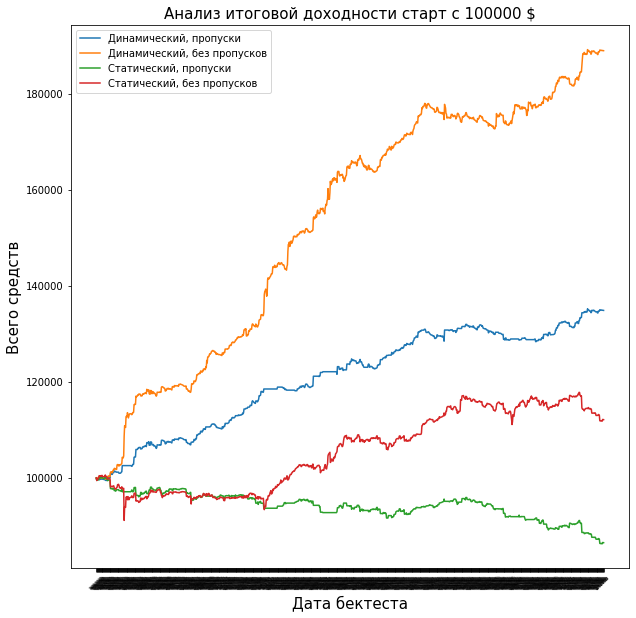

In [522]:
start_amount = 100000
gas_price = 8 # за одну операцию, внутри умножение на 2
dyn_no_wait = back_test_obj.plot_results_alt(start_amount = start_amount, gas_price = gas_price,
                               verbose=False, hedge_type='dynamic', wait_dangerous=False,
    plot=False)
dyn_wait = back_test_obj.plot_results_alt(start_amount = start_amount, gas_price = gas_price,
                               verbose=False, hedge_type='dynamic', wait_dangerous=True,
    plot=False)
static_wait = back_test_obj.plot_results_alt(start_amount = start_amount, gas_price = gas_price,
                               verbose=False, hedge_type='simple', wait_dangerous=True,
    plot=False)
static_no_wait = back_test_obj.plot_results_alt(start_amount = start_amount, gas_price = gas_price,
                               verbose=False, hedge_type='simple', wait_dangerous=False,
    plot=False)
x = dyn_wait[0]
plt.plot(x, dyn_wait[1], label='Динамический, пропуски')
plt.plot(x, dyn_no_wait[1], label='Динамический, без пропусков')
plt.plot(x, static_wait[1], label='Статический, пропуски')
plt.plot(x, static_no_wait[1], label='Статический, без пропусков')
plt.xlabel('Дата бектеста', fontsize=15)
plt.ylabel('Всего средств', fontsize=15)
plt.xticks(fontsize = (50/len(x)+3), 
           rotation=45)
plt.title('Анализ итоговой доходности старт с {} $'.format(start_amount), fontsize = 15)
plt.legend(prop={'size': 10})
plt.show()



### Рассмотрим как изменялся курс ETH/USDT

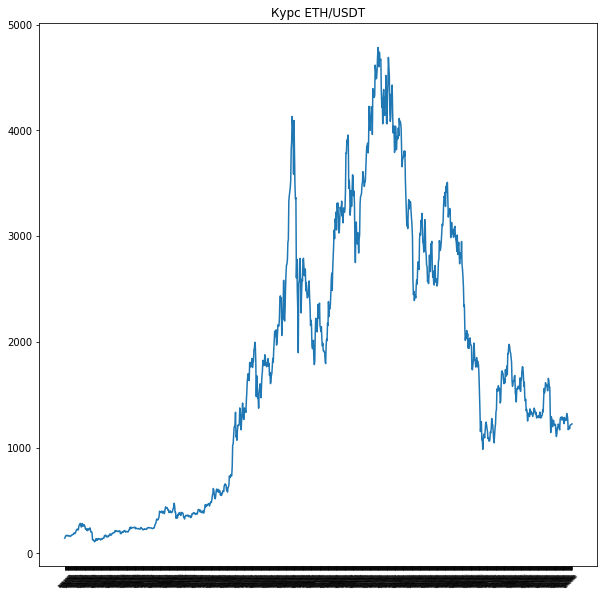

In [471]:
back_test_obj.plot_price()

### Дополнительно проверим как распределены изменения в стоимости (после 24 часов)¶


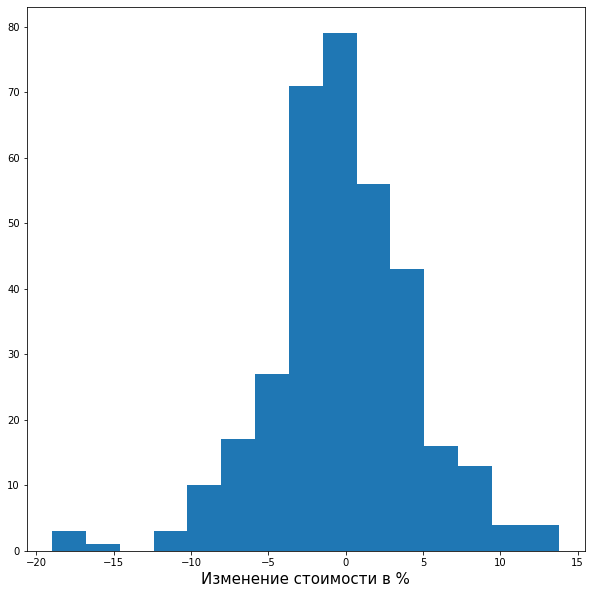

In [887]:
back_test_obj.change_price_distr()

### Рассмотрим применимость нашей теории - зависимость будущей волатильности от прошлой
Идея заключается в следующем. Мы зарабатываем только когда волатильность небольшая, если мы видим большую волатильность в прошлом, возможно стоит не минимизировать убытки, а просто подождать, пока рынок успокоится.

In [422]:
dict_sets = back_test_obj.dict_res

In [423]:
def calc_vol(prev_diff, future_diff):
    """Функция выдает прошлую и будущую волатильности"""
    # рассчитаем волотильность как разницу между максимальным и минимальным значениями
    # добавим 1 в самое начало
    prev_diff = np.array([1]+list(prev_diff))
    future_diff = np.array([1]+list(future_diff))
    prev_bahavour = np.cumprod(prev_diff)
    future_bahavour = np.cumprod(future_diff)
    prev_vol = np.max(prev_bahavour)-np.min(prev_bahavour)
    future_vol = np.max(future_bahavour)-np.min(future_bahavour)
#     prev_diff_abs = np.mean(np.abs(prev_diff - 1))
#     future_diff_abs = np.mean(np.abs(future_diff - 1))
    return prev_vol, future_vol
    
    

In [424]:
correlation_mat = np.zeros((len(dict_sets), 2))
k = 0
for key in dict_sets:
    prev = dict_sets[key][0]
    future = dict_sets[key][1]
    prev = prev['change'].values
    future = future['change'].values
    correlation_mat[k, :] = calc_vol(prev, future)
    k += 1
    

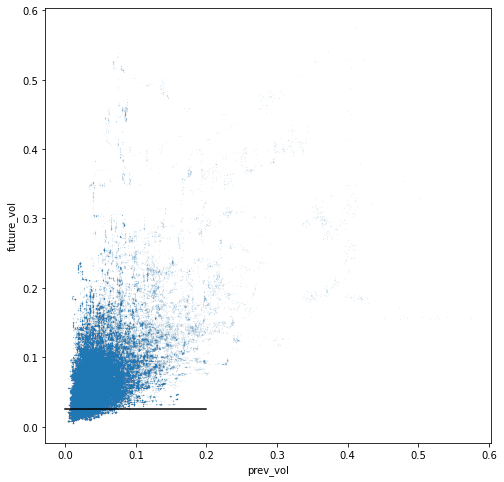

In [425]:
plt.figure(figsize=(8,8))
plt.scatter(correlation_mat[:, 0], correlation_mat[:, 1], s=0.001)
plt.xlabel('prev_vol')
plt.ylabel('future_vol')
plt.plot([0,0.2], [0.025, 0.025], c='0')

### Вывод - не имеет смысла выставляться, если волотильность в прошлом была более чем 5%!, это лишь принесет нам убытки, лучше переждать. Нужно протестировать данную стратегию

#### Теория теорией, а что на практике? рассмотрим график прибыли/убытков в зависимости от величины предсказанного интервалла

In [431]:
# сначала сохраним в экземпляр класса параметры(они сохраняются по ходу построение прогноза)
dyn_no_wait = back_test_obj.plot_results_alt(start_amount = start_amount, gas_price = gas_price,
                               verbose=False, hedge_type='dynamic', wait_dangerous=False,
    plot=False)

требуется плечо -  4


<Figure size 720x720 with 0 Axes>

(0.0, 0.55)

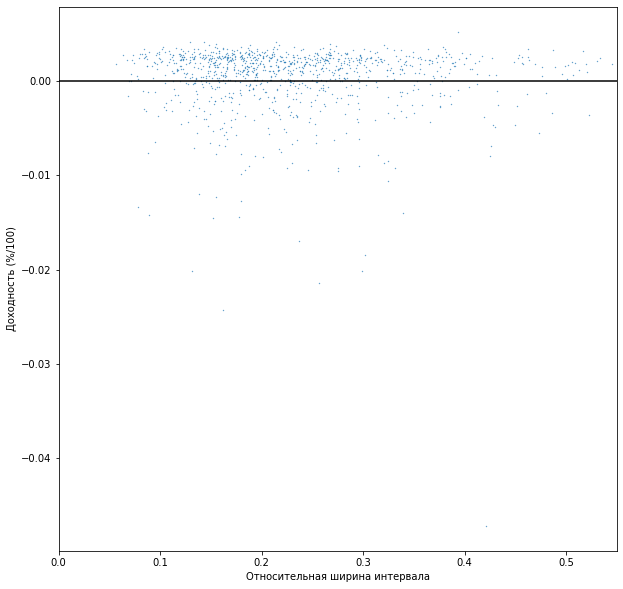

In [434]:
plt.figure(figsize=(10, 10))
plt.scatter(back_test_obj.mas_earn_inter[:, 0], back_test_obj.mas_earn_inter[:, 1], s=0.1)
plt.plot([0, 1], [0, 0], c='black')
plt.xlabel('Относительная ширина интервала')
plt.ylabel('Доходность (%/100)')
plt.xlim([0,0.55])

#### Рассмотрим как распределены изменения цены более детально. Больше точек в n_forecast*interval_in_hour раз // Тут за 25 часов мы получаем очень много точек, старт в 5 минуту, в 10ю минуту, все эти старты приносят нам по одной точке. Вверху мы просто смотрели одну точку за 24 часа, 2 точки за 48 часов.

In [888]:
def make_diff(df, int_in_h, n_forcast):
    res = np.zeros(len(df)-n_forcast*int_in_h)
    opens = df['open'].values.astype(float)
    closes = df['close'].values.astype(float)
    for i in range(len(res)):
        start = opens[i]
        end = closes[i+n_forcast*int_in_h-1]
        res[i] = (end-start)/start*100
    return res

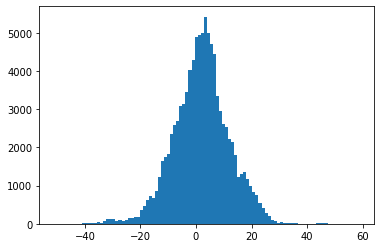

In [937]:
plt.hist(make_diff(df, 12, 96), bins=100)
plt.show()

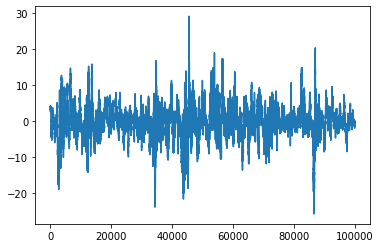

In [998]:
# тоже самое только другим способом
plt.plot(make_diff(df, 12, 24))
plt.show()

### Синтетический тест - натравим изменения за год на наш интервал, прикинем какая должна быть доходность для выхода в +

In [1011]:
# изменения за год
diff = make_diff(df, 12, 24)

res = np.zeros(len(diff))
current_amount = 10000
start_price = 1222
high_board = 1350
low_board = 1150

earnings = 0.6

k = 0
for d in diff:
    end_price = start_price*(1+d/100)
    res[k] = new_simulate(current_amount, start_price, end_price, high_board, low_board,  earnings)
    k += 1

In [1012]:
np.sum(res)

1395.7501768605075

#### Вывод - около 0.6% в сутки должно быть достаточно

# проверка логики работы

In [169]:
# Функция для построения кривой
def simulate(start_price, end, high_board, low_board, hedge, earnings):
    a1 = unforward_earnings(start_price, end, high_board, low_board)
    a2 = earnings
    a3 = -hedge*(end - start_price)/start_price*100
    return a1+a2+a3

### новая схема, проверка симметрии(еще раз проверим, что все симметрично, не смотря на уход части средств в хедж) Спойлер - все симметрично, просто доходность падает пропорционально тому, сколько средств ушло в хедж (они не работают)


In [74]:


def new_simulate(current_amount, start_price, end_price, high_board, low_board,  earnings):
    ratio_hedge = calc_ratio(start_price, high_board, low_board)
    eth_pool = ratio_hedge*current_amount/(1+ratio_hedge)
    usd_pool = current_amount - 2*eth_pool
    usd_hedge = eth_pool

    # Получим непрямые прибыли/убытки от пула в процентах
    e1 = unforward_earnings(start_price, end_price, high_board, low_board)
    e1 = e1/100*(eth_pool+usd_pool) # переведем в деньги: прибыль

    # получим прибыль/убыток от хеджа
    e2 = simple_hedge(start_price, end_price, ratio_hedge)
    # небольшой костыль, чтобы вернуться просто к процентам от хеджа
    e2 = e2/(100*ratio_hedge)
    e2 = usd_hedge*e2  # переведем в доллары

    # получим прибыль от стейкинга
    e3 = earnings
    e3 = e3/100 # уход от %
    e3 = (eth_pool+usd_pool)*e3# переведем в деньги
    # суммируем прибыли и изначальную сумму
    earn = e1 + e2 + e3 + current_amount
    return (earn-current_amount)/current_amount*100

### Сравним поведение при широком и узком интервале (доходности заданы как 0.5 и 0.25%)

In [449]:
current_amount = 10000
start_price = 1222
high_board_wide = 1340
low_board_wide = 1100
high_board = 1260
low_board = 1195
earnings_wide = 5
earnings = 2


In [450]:
end_prises = list(range(1000,1400))
list2 = list(map((lambda x: new_simulate(current_amount, start_price, x, high_board, low_board, earnings)), end_prises))
list3 = list(map((lambda x: (x-start_price)/start_price*100), end_prises))
list5 = list(map((lambda x: new_simulate(current_amount, start_price, x, high_board_wide, low_board_wide, earnings_wide)), end_prises))





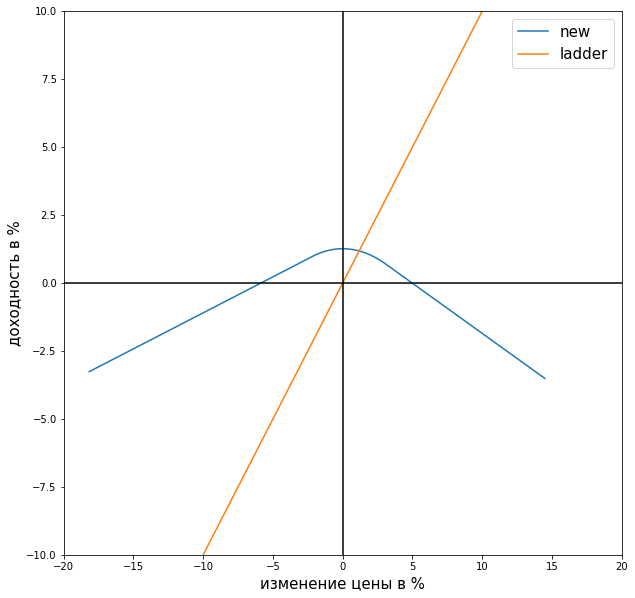

In [451]:
plt.figure(figsize=(10,10))
plt.plot(list3, list2, label='new')
# plt.plot(list3, list5, label='new_wide')
# plt.plot(list3, list4, label='old')
plt.plot(list3, list3, label='ladder')
plt.plot([0, 0], [-20, 20], c='black')
plt.plot([-20, 20], [0, 0], c='black')
plt.xlabel('изменение цены в %', fontsize=15)
plt.ylabel('доходность в %', fontsize=15)
plt.ylim([-10, 10])
plt.xlim([-20, 20])
plt.legend(prop={'size':15})

#### Вывод - широкий интервалл более вытянутый, но не такой доходный в горбе, ожидаемый результат

#### Сравним с тем, что было раньше - когда фьючерсы были бесплатные

In [606]:
# тут требуется вводить хедж
hedge = 0.57

In [607]:
list4 = list(map((lambda x: simulate(start_price, x, high_board, low_board, hedge, earnings)), end_prises))

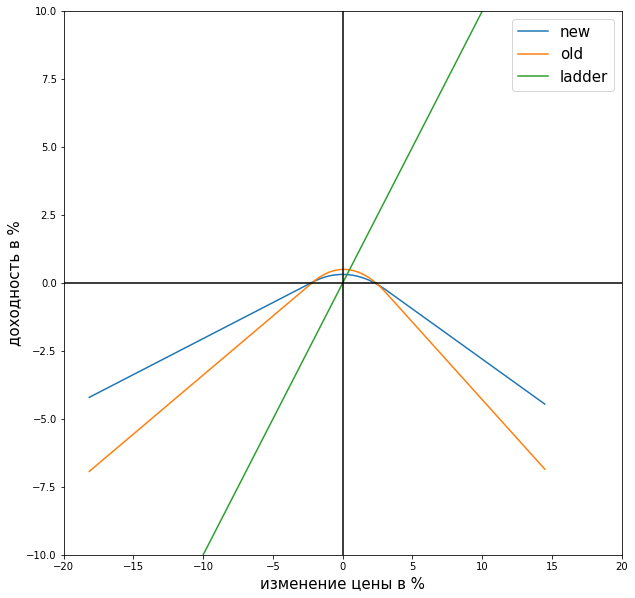

In [608]:
plt.figure(figsize=(10,10))
plt.plot(list3, list2, label='new')
plt.plot(list3, list4, label='old')
plt.plot(list3, list3, label='ladder')
plt.plot([0, 0], [-20, 20], c='black')
plt.plot([-20, 20], [0, 0], c='black')
plt.xlabel('изменение цены в %', fontsize=15)
plt.ylabel('доходность в %', fontsize=15)
plt.ylim([-10, 10])
plt.xlim([-20, 20])
plt.legend(prop={'size':15})

In [ ]:
хедж
        пул usd
        pool eth
при движении на +5%, в пуле +3% хедж -5%



##### Вывод, бесплатные фьючерсы конечно приносят большую дохоность при низкой волотильности, однако несут бОльшие убытки при резком изменении цены.

# Прогнозы в реальном времени

###  Функции и зависимости 

In [395]:
from datetime import datetime, timedelta
def dataset_for_current_pred(symbol = 'ETHUSDT'):
  '''Функция возвращает последние доступные данные'''
  api_key = ""
  api_secret = ""
  client = Client(api_key, api_secret)
  current_date = datetime.now().strftime("%d-%m-%Y")
  yesterday = (datetime.now()+timedelta(days=-1)).strftime("%d/%m/%Y")
  tommorow = (datetime.now()+timedelta(days=+1)).strftime("%d/%m/%Y") 

  fromDate = str(datetime.strptime(yesterday, '%d/%m/%Y'))
  toDate = str(datetime.strptime(tommorow, '%d/%m/%Y'))
  symbol = symbol
  interval = Client.KLINE_INTERVAL_5MINUTE
  # посколько реализована подгрузка начиная со вчерашнего дня, разумно обрезать датасет 24 часами 24*60=1440
  df = GetHistoricalData(symbol, interval, fromDate, toDate)[-288:] 
  return df

def bootstrap(mass, n_forcast, intervals_in_hour):
    '''Функция бутстрэпит изменения за прошедшие часы (это длина массива) n_forcast*intervals_in_hour раз, 
    процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
    mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
    mass = np.array(mass) # переводим в numpy
    n = len(mass) # длина выборки для обучения
    size_forecast = n_forcast*intervals_in_hour
    # случайно берем числа до n, размера n_forcast*intervals_in_hour
    indexes = np.random.randint(n, size=size_forecast*10000)
    change = mass[[indexes]]
    change = change.reshape((10000, size_forecast))
    # теперь рассомтрим куммулятивное перемножение- предсказанное поведение
    cum_change = np.cumprod(change, axis=1)
    # минимальное и максимальные значения внутри временного интервалла
    min_ = np.min(cum_change, axis=1)
    max_ = np.max(cum_change, axis=1)
    sorted_res_min = np.sort(min_)
    sorted_res_max = np.sort(max_)
    #######################
    high, low = sorted_res_max[9500], sorted_res_min[500]
    return np.array([high, low])
def make_new_col(df):
    '''Потребуются относительные изменения'''
    print('Добавляю относительные изменения')
    mass = np.zeros(len(df))
    mass[0] = 1 # первую точку доопределяем 1
    values = df['open'].values.astype(float)
    for i in range(1, len(df)):
        mass[i] = values[i]/values[i-1]
        df['change'] = mass
    return df

def calc_ratio(start_price, high_board, low_board):
    return (high_board-start_price)/(high_board-low_board)

### Требуется ввести сумму средств

In [396]:
# требуется ввести сумму средств
current_amount = 10000
n_forcast, intervals_in_hour = 24, 12

### Запускаем расчет

In [397]:

#Получаем данные
df_current = dataset_for_current_pred()

# Добавляем новую колонку
df_current = make_new_col(df_current)

# требуется для абсолютных значений запомнить текущую
current_value = df_current['open'].values.astype(float)[-1]
# Рассчитываем сам интервал
res_interval = bootstrap(df_current['change'].values, n_forcast=24, intervals_in_hour=60)*current_value

# рассчитываем ratio_hedge
start_price = current_value
high_board = res_interval[0]
low_board = res_interval[1]

ratio_hedge = calc_ratio(start_price, high_board, low_board)

eth_pool = ratio_hedge*current_amount/(1+ratio_hedge)
usd_pool = current_amount - 2*eth_pool
usd_hedge = eth_pool

print('Распределение средств в долларах')
print('Сумма эфира(в usdt) в пул', eth_pool)
print('Сумма usdt в пул', usd_pool)
print('Покупка фьючерса ',usd_hedge)

Добавляю относительные изменения


<ipython-input-395-ac082a017383>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  change = mass[[indexes]]


Распределение средств в долларах
Сумма эфира(в usdt) в пул 3074.538165320542
Сумма usdt в пул 3850.9236693589164
Покупка фьючерса  3074.538165320542


In [398]:
res_interval

array([1277.9662172 , 1089.57388019])

In [400]:
current_value

1194.33

In [ ]:
def calc_ratio(start_price, high_board, low_board):
    return (high_board-start_price)/(high_board-low_board)

In [169]:
calc_ratio(start, high, low)

0.5248259860788849

In [170]:
(1195.48+1101.25)*0.524825986

1205.38358682578

###  Распределение ликвидности

In [151]:
start = 1195.48
high = 1218.1
low = 1175
eth_amount = 1
usdt_amount = 1101.25 

In [153]:
usdt_amount/(start-low)

53.77197265624995

In [163]:
eth_amount*start/(high-start)

52.85057471264393

In [156]:
eth_amount*start/(get_tick(high)-get_tick(start))

6.3589361702127665

In [157]:
usdt_amount/(get_tick(start)-get_tick(low)) 

6.365606936416185

In [164]:
6.3656/6.3589

1.0010536413530642

In [165]:
53.771/52.8505

1.017417053764865

In [148]:
def get_tick(price):
    """функция возвращает в какую степень нужно возвести 1.0001"""
    return int(math.log(price, 1.0001))

In [159]:
1200-1000

200

In [160]:
get_tick(1200)-get_tick(1000)

1823

In [161]:
1000-800

200

In [162]:
get_tick(1000)-get_tick(800)

2232

In [145]:
import math

In [149]:
get_tick(1218.1)-

70904

## Планы/идеи: 
1) Протестировать, как зависят обьемы от ширины интервала - данные из uniswap(обьемы) и бинанса(волатильность цены)  
2) Ожидать, но не сидеть весь день(проверять каждый час)  
3) Делать выход из сделки за один час в лучший момент (в достаточно близкий)